In [2]:
import math
import random
import numpy as np
from itertools import product

from qiskit import *

# Importing standard Qiskit libraries
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator

from qiskit.utils import QuantumInstance

from qiskit.opflow import I, X, Y, Z

from qiskit.opflow import StateFn
from qiskit.opflow import Gradient
from qiskit.opflow import CircuitSampler
from qiskit.opflow.primitive_ops import MatrixOp
from qiskit.extensions.unitary import UnitaryGate
from qiskit.circuit.library.standard_gates import CZGate
from qiskit.circuit.library.standard_gates import RXGate
from qiskit.circuit.library.standard_gates import RYGate
from qiskit.circuit.library.standard_gates import RZGate

from qiskit.quantum_info import Statevector

from qiskit.providers.aer.noise import NoiseModel
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

In [3]:
def getThetaList():
    thetaList = []
    for i in range(11):
        thetaList.append(2*np.arccos(1/np.sqrt(12-i)))
    return thetaList

In [4]:
def createEqSuperposCollectiveU():
    #Creates a one-hot encoding on 12 qubits
    temp = QuantumCircuit(12)
    thetaList = getThetaList()
    temp.ry(thetaList[0], 10)
    temp.x(11)
    temp.cx(10, 11)
    
    for i in range(10):
        temp.append(RYGate(thetaList[i+1]).control(1), [10-i, 9-i])
        temp.cx(9-i, 10-i)
    
    return temp

In [5]:
#backend = Aer.get_backend('statevector_simulator')
#result = execute(createEqSuperposCollectiveU().reverse_bits(), backend).result().get_statevector()
#for i in range(len(result)):
#    if np.abs(result[i])>=1e-6:
#        print(i, result[i])

In [6]:
def Bx():
    temp = QuantumCircuit(2)
    temp.append(RXGate(np.pi/2), [0])
    temp.append(RXGate(np.pi/2), [1])
    return temp

In [7]:
def By():
    temp = QuantumCircuit(2)
    temp.append(RYGate(np.pi/2), [0])
    temp.append(RYGate(np.pi/2), [1])
    return temp

In [8]:
def Bz():
    temp = QuantumCircuit(2)
    temp.append(RZGate(np.pi/2), [0])
    temp.append(RZGate(np.pi/2), [1])
    return temp

In [9]:
def createOplist():
    #Check ordering of gates
    
    opList = []
    temp = QuantumCircuit(2)
    temp.append(RYGate(0), [0])
    temp.append(RYGate(0), [1])
    opList.append(temp)
    
    opList.append(Bx().compose(Bx()))
    opList.append(By().compose(By()))
    opList.append(Bz().compose(Bz()))
    
    
    opList.append(By().compose(Bx()))
    opList.append(Bz().compose(By()))
    opList.append(Bx().compose(Bz()))
    opList.append(Bx().compose(By()))
    
    temp = By().compose(Bx())
    opList.append(temp.compose(temp))
    
    temp = Bz().compose(By())
    opList.append(temp.compose(temp))
    
    temp = Bx().compose(Bz())
    opList.append(temp.compose(temp))
    
    temp = Bx().compose(By())
    opList.append(temp.compose(temp))
    
    return opList

In [10]:
#Unitary to create state \rho
size = 4
state = QuantumCircuit(size)

state.h(0)
state.h(1)
state.cx(0, 2)
state.cx(1, 3)
state.draw()

┌───┐          
q_0: ┤ H ├──■───────
     ├───┤  │       
q_1: ┤ H ├──┼────■──
     └───┘┌─┴─┐  │  
q_2: ─────┤ X ├──┼──
          └───┘┌─┴─┐
q_3: ──────────┤ X ├
               └───┘

In [11]:
def createQuantumCircuit():
    circ = QuantumCircuit(16)
    #Create Quantum Circuit here
    
    superPosCircuit = createEqSuperposCollectiveU()
    circ.append(superPosCircuit, range(12))
    circ.append(state, [12, 13, 14, 15])
    
    #opList = createOplist()
    #for i in range(12):
    #    circ.append(opList[i].control(1), [i, 12, 13])
    
    circ.append(superPosCircuit.inverse(), range(12))

    return circ

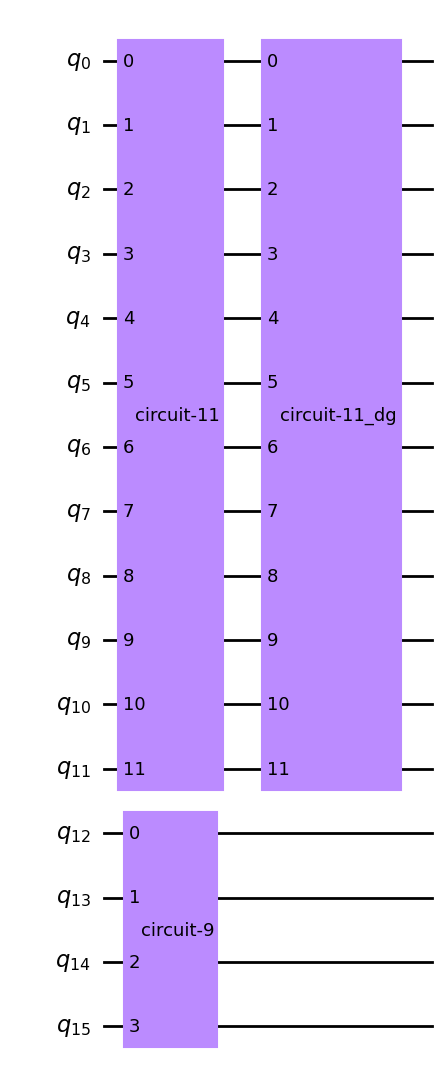

In [12]:
qCirc = createQuantumCircuit()
qCirc.draw('mpl')

In [15]:
#Create Hamiltonian here
hamiltonian = I^I^I^I^I^I^MatrixOp(np.array([[1, 0], [0, 0]]))^MatrixOp(np.array([[1, 0], [0, 0]]))^MatrixOp(np.array([[1, 0], [0, 0]]))

In [16]:
#use if noiseless
noiseless_backend = Aer.get_backend('statevector_simulator')
noiseless_q_instance = QuantumInstance(noiseless_backend)
noiseless_sampler = CircuitSampler(noiseless_q_instance)

In [17]:
'''
Pick a backend to use. We use the qasm_simulator for noisy simulation. 
'''
#Replace the provider with your personal credentials for hub, group and main
provider = IBMQ.get_provider(hub="ibm-q-research", group="louisiana-st-uni-1", project="main")

noisy_backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibmq_jakarta")
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())
noisy_q_instance = QuantumInstance(backend=noisy_backend, 
                           shots=8192, 
                           noise_model=noise_model, 
                           coupling_map=coupling_map,
                           measurement_error_mitigation_cls=CompleteMeasFitter,
                           cals_matrix_refresh_period=30)
noisy_sampler = CircuitSampler(noisy_q_instance)

In [18]:
def costf(noisy = False):
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    
    if noisy:
        result = noisy_sampler.convert(expectation).eval()  
    else:
        result = noiseless_sampler.convert(expectation).eval()  
    
    return np.real(result)

In [ ]:
print("Initial Cost : ", costf())